In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

%load_ext autoreload
%autoreload 2
from survey_medley_code.config_loader import load_config
from survey_medley_code.within_subject_modeling.io_utils import (
    get_confounds_data,
    get_subids_bids_dir,
    load_tsv_data,
    resolve_file,
)

## What's in here?
This is a collection of quick analyses to gain insight into what the data look like.  For example, who is missing data, who is missing responses to questions, etc.

In [2]:
cfg = load_config()
subids = get_subids_bids_dir(cfg)


## Who has too many high motion volumes?

In [3]:
# Check how many subjects have more than 20% high motion
high_motion_subs = []
high_motion_vals = []

for subid in subids:
    try:
        # Try to get the confounds file
        confounds_file = resolve_file(cfg, subid, 'confounds')
    except ValueError:
        # File not found — skip this subject
        print(f'Skipping sub-{subid}: confounds file not found')
        continue

    # If we got the file, check high motion.  We've used a .2 cutoff in the past
    _, percent_high_motion = get_confounds_data(confounds_file)
    if percent_high_motion > 0.2:
        high_motion_subs.append(subid)
        high_motion_vals.append(percent_high_motion)
        print(f'High motion: sub-{subid}')

Skipping sub-s144: confounds file not found
High motion: sub-s471
Skipping sub-s533: confounds file not found
Skipping sub-s599: confounds file not found
Skipping sub-s600: confounds file not found
Skipping sub-s603: confounds file not found
Skipping sub-s639: confounds file not found
High motion: sub-s644


In [4]:
# We'll need to be sure to leave these two out
print(high_motion_subs)
print(high_motion_vals)

['s471', 's644']
[np.float64(0.31893687707641194), np.float64(0.29900332225913623)]


## How many people are missing response to questions?

In [5]:
missing_response_subids = []
missing_response_questions = []
missing_response_questionnaire = []
missing_response_key_press = []

for subid in subids:
    try:
        # Try to get the behavioral file
        behav_file = resolve_file(cfg, subid, 'behav')
    except ValueError:
        print(f'Skipping sub-{subid}: behav file not found')
        continue

    # Load the events data
    events = load_tsv_data(behav_file)

    # Identify rows where response_time is missing
    missing_mask = events['response_time'].isna()
    if missing_mask.any():
        missing_rows = events.loc[missing_mask, ['trial_type', 'survey', 'key_press']]
        # Append info for each missing row
        missing_response_subids.extend([subid] * len(missing_rows))
        missing_response_questions.extend(missing_rows['trial_type'].tolist())
        missing_response_questionnaire.extend(missing_rows['survey'].tolist())
        missing_response_key_press.extend(missing_rows['key_press'].tolist())

# Optionally, create a DataFrame for easy inspection
missing_responses_df = pd.DataFrame(
    {
        'subid': missing_response_subids,
        'trial_type': missing_response_questions,
        'survey': missing_response_questionnaire,
        'key_press': missing_response_key_press,
    }
)

Skipping sub-s144: behav file not found
Skipping sub-s533: behav file not found
Skipping sub-s600: behav file not found
Skipping sub-s603: behav file not found
Skipping sub-s639: behav file not found
Skipping sub-s640: behav file not found


### Focus on subjects missing responses for any questions

If subjects are missing responses, they are more likely to be missing responses for impulsive venture.

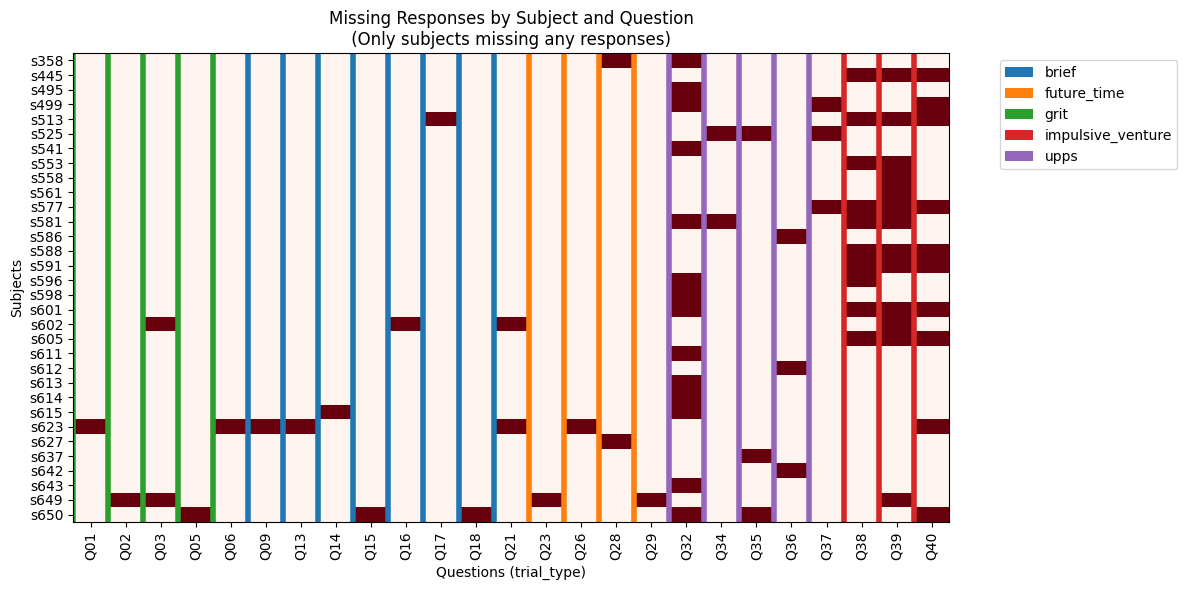

In [6]:
# Make sure trial_type is sorted (Q01, Q02, ...)
missing_responses_df = missing_responses_df.copy()
missing_responses_df['trial_type'] = missing_responses_df['trial_type'].astype(str)

# Create pivot table: rows=subid, cols=trial_type, values=1 if missing, else 0
pivot = missing_responses_df.assign(missing=1).pivot_table(
    index='subid', columns='trial_type', values='missing', fill_value=0
)

# Sort columns (Q01, Q02, ...)
pivot = pivot.reindex(sorted(pivot.columns), axis=1)

# Map trial_type to survey (used for color bars)
trial_to_survey = (
    missing_responses_df.drop_duplicates(subset=['trial_type'])
    .set_index('trial_type')['survey']
    .to_dict()
)

surveys = np.sort(missing_responses_df['survey'].unique())
survey_colors = dict(zip(surveys, sns.color_palette('tab10', n_colors=len(surveys))))

# Plot the missing responses raster
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pivot.values, aspect='auto', cmap='Reds', interpolation='none')

# y-axis: subjects
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)

# x-axis: trial_types
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=90)

# Add survey color bars below the x-axis
for i, trial in enumerate(pivot.columns):
    survey = trial_to_survey[trial]
    ax.axvline(i - 0.5, color=survey_colors[survey], linewidth=4)

# Optional: add legend for survey colors
legend_elements = [
    Patch(facecolor=color, label=survey) for survey, color in survey_colors.items()
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Questions (trial_type)')
ax.set_ylabel('Subjects')
ax.set_title(
    'Missing Responses by Subject and Question\n (Only subjects missing any responses) '
)
plt.tight_layout()
plt.show()

## I wonder if missing responses is related to the number of words in the question

In [7]:
word_count_counts = []
word_count_rts = []
word_count_subids = []
word_count_trial_types = []
word_count_surveys = []
word_count_num_possible_responses = []
word_count_key_press = []
word_count_coded_response = []  # NEW

for subid in subids:
    try:
        # Try to get the behavioral file
        behav_file = resolve_file(cfg, subid, 'behav')
    except ValueError:
        print(f'Skipping sub-{subid}: behav file not found')
        continue

    # Load the events data
    events = load_tsv_data(behav_file)

    # Count words in item_text for each row
    counts = events['item_text'].astype(str).str.split().str.len()

    # Count number of possible responses per row
    num_possible_responses = (
        events['possible_responses'].fillna('').astype(str).str.split(',').str.len()
    )

    # Append results for this subject
    word_count_counts.extend(counts.tolist())
    word_count_rts.extend(events['response_time'].tolist())  # keeps NaN
    word_count_subids.extend([subid] * len(events))
    word_count_trial_types.extend(events['trial_type'].tolist())
    word_count_surveys.extend(events['survey'].tolist())
    word_count_num_possible_responses.extend(num_possible_responses.tolist())
    word_count_key_press.extend(events['key_press'].tolist())
    word_count_coded_response.extend(events['coded_response'].tolist())  # NEW

# Combine into a single DataFrame
word_count_df = pd.DataFrame(
    {
        'subid': word_count_subids,
        'trial_type': word_count_trial_types,
        'survey': word_count_surveys,
        'word_count': word_count_counts,
        'num_possible_responses': word_count_num_possible_responses,
        'response_time': word_count_rts,
        'key_press': word_count_key_press,
        'coded_response': word_count_coded_response,  # NEW
    }
)


Skipping sub-s144: behav file not found
Skipping sub-s533: behav file not found
Skipping sub-s600: behav file not found
Skipping sub-s603: behav file not found
Skipping sub-s639: behav file not found
Skipping sub-s640: behav file not found


### Repeat earlier figure with all subjects

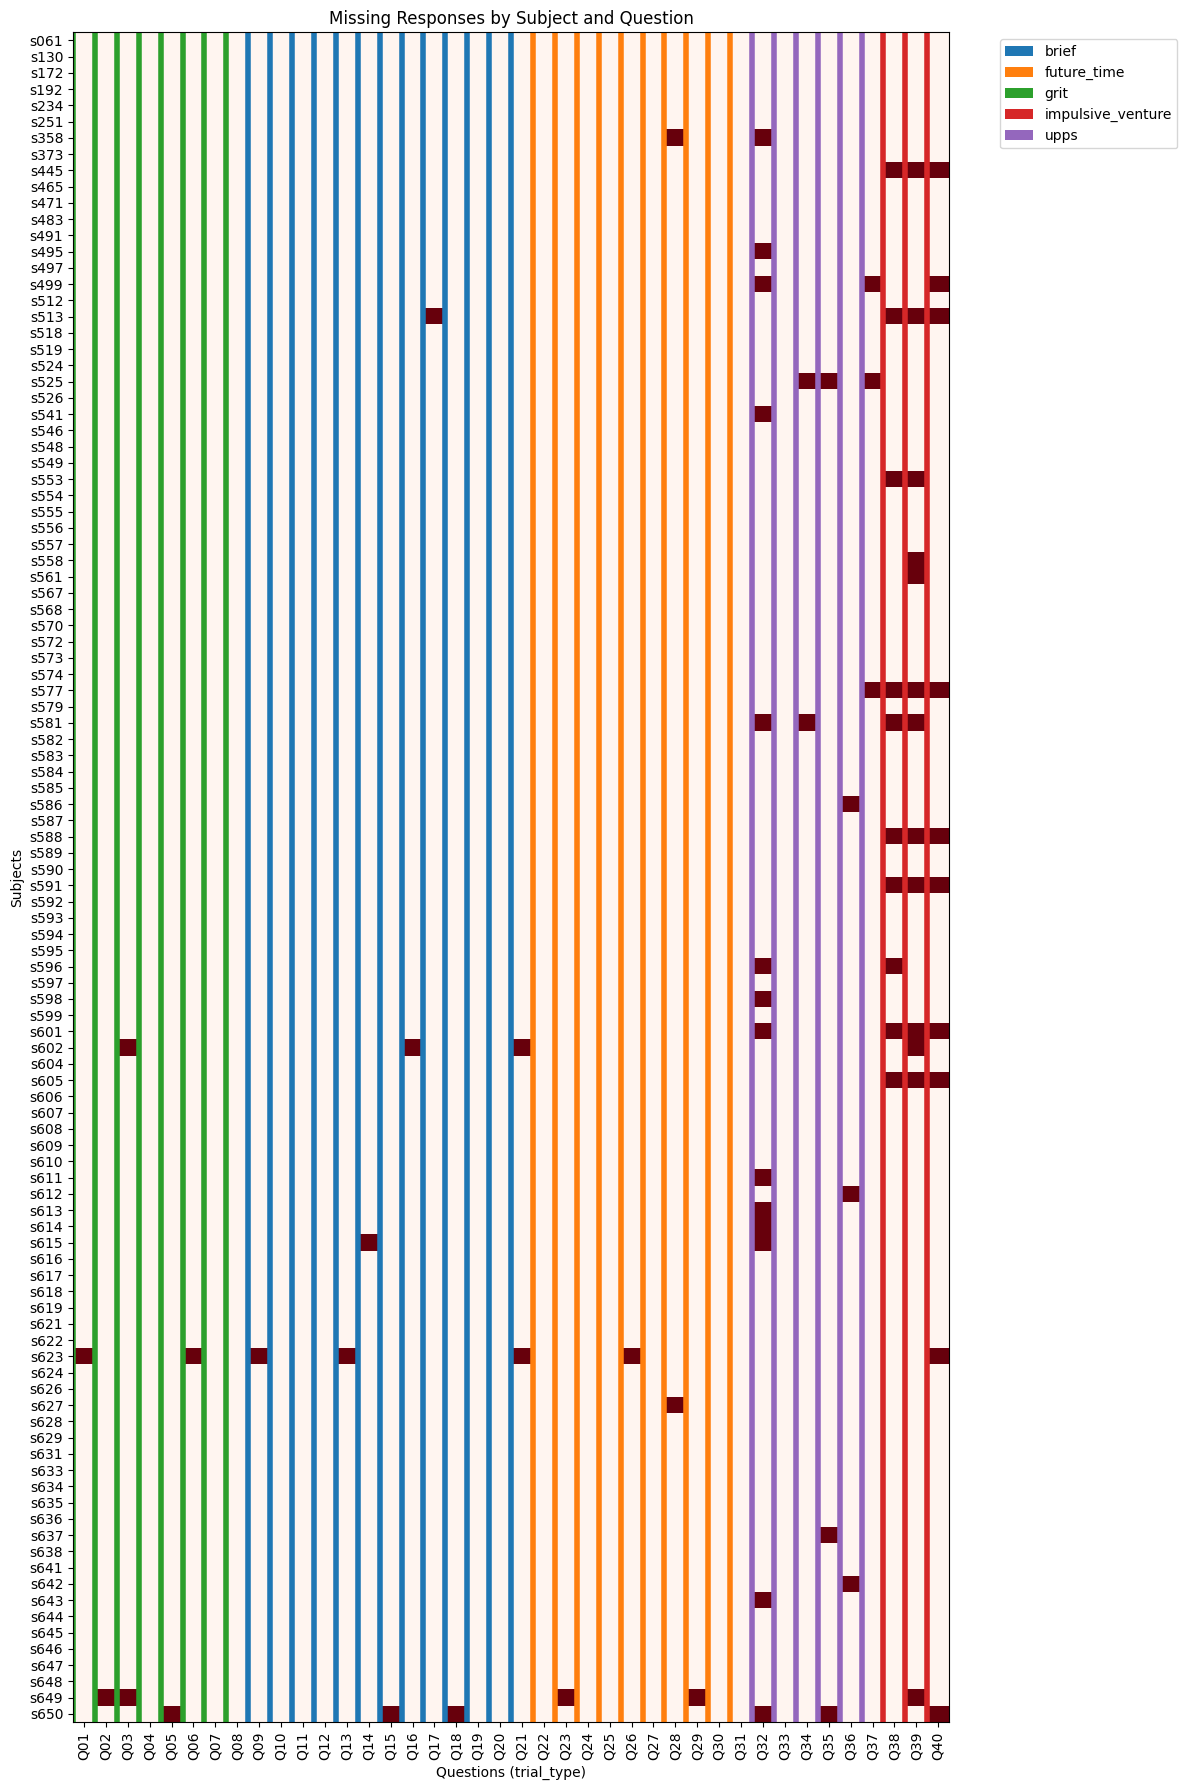

In [8]:
# repeat the above figure, but with all subjects
# Filter to missing response_time
missing_df = word_count_df[word_count_df['response_time'].isna()].copy()
missing_df['trial_type'] = missing_df['trial_type'].astype(str)

# Create pivot table: rows=subid, cols=trial_type, values=1 if missing, else 0
pivot = word_count_df.assign(
    missing=word_count_df['response_time'].isna().astype(int)
).pivot_table(index='subid', columns='trial_type', values='missing', fill_value=0)

# Sort columns by trial_type (Q01, Q02, etc)
pivot = pivot.reindex(sorted(pivot.columns), axis=1)

# Map trial_type to survey
trial_to_survey = (
    word_count_df.drop_duplicates(subset=['trial_type'])
    .set_index('trial_type')['survey']
    .to_dict()
)

# Create a color palette for surveys
surveys = np.sort(word_count_df['survey'].unique())
survey_colors = dict(zip(surveys, sns.color_palette('tab10', n_colors=len(surveys))))

# Plot the missing responses raster
fig, ax = plt.subplots(figsize=(12, 18))
im = ax.imshow(pivot.values, aspect='auto', cmap='Reds', interpolation='none')

# y-axis: subjects
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)

# x-axis: trial_types
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=90)

# Add survey color bars below the x-axis
for i, trial in enumerate(pivot.columns):
    survey = trial_to_survey[trial]
    ax.axvline(i - 0.5, color=survey_colors[survey], linewidth=4)

# Add legend for survey colors
legend_elements = [
    Patch(facecolor=color, label=survey) for survey, color in survey_colors.items()
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('Questions (trial_type)')
ax.set_ylabel('Subjects')
ax.set_title('Missing Responses by Subject and Question')
plt.tight_layout()
plt.show()

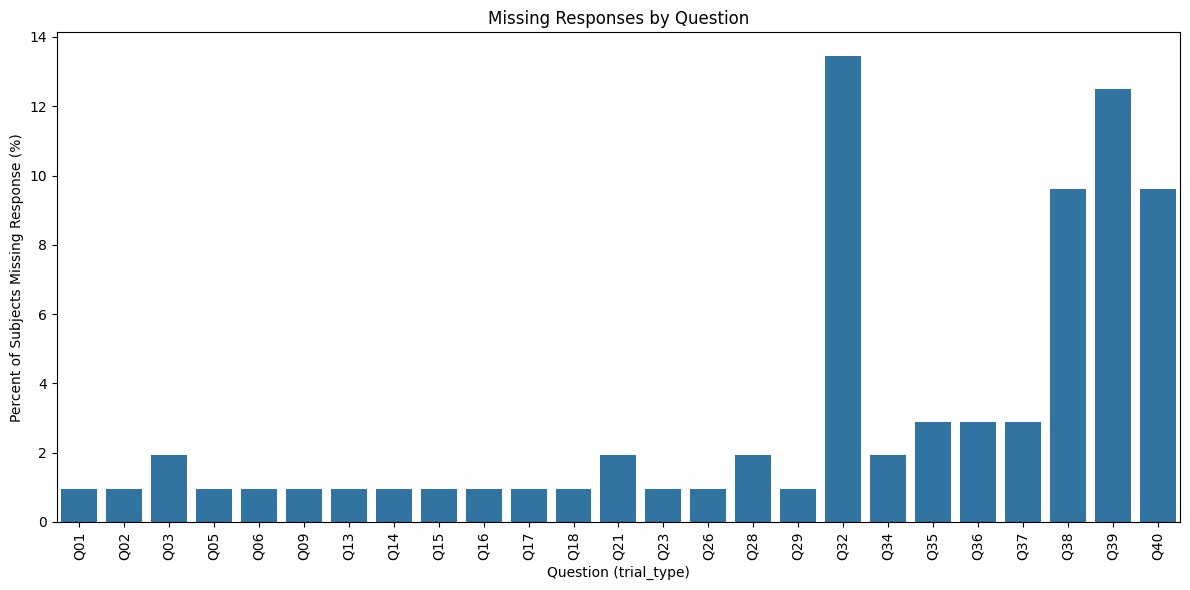

In [9]:
missing_df = word_count_df[word_count_df['response_time'].isna()]

# Count missing responses per trial_type (question)
missing_counts = missing_df['trial_type'].value_counts().sort_index()

# Convert counts to percent of subjects
total_subs = word_count_df['subid'].nunique()
missing_percent = (missing_counts / total_subs) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)

plt.xlabel('Question (trial_type)')
plt.ylabel('Percent of Subjects Missing Response (%)')
plt.title('Missing Responses by Question')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

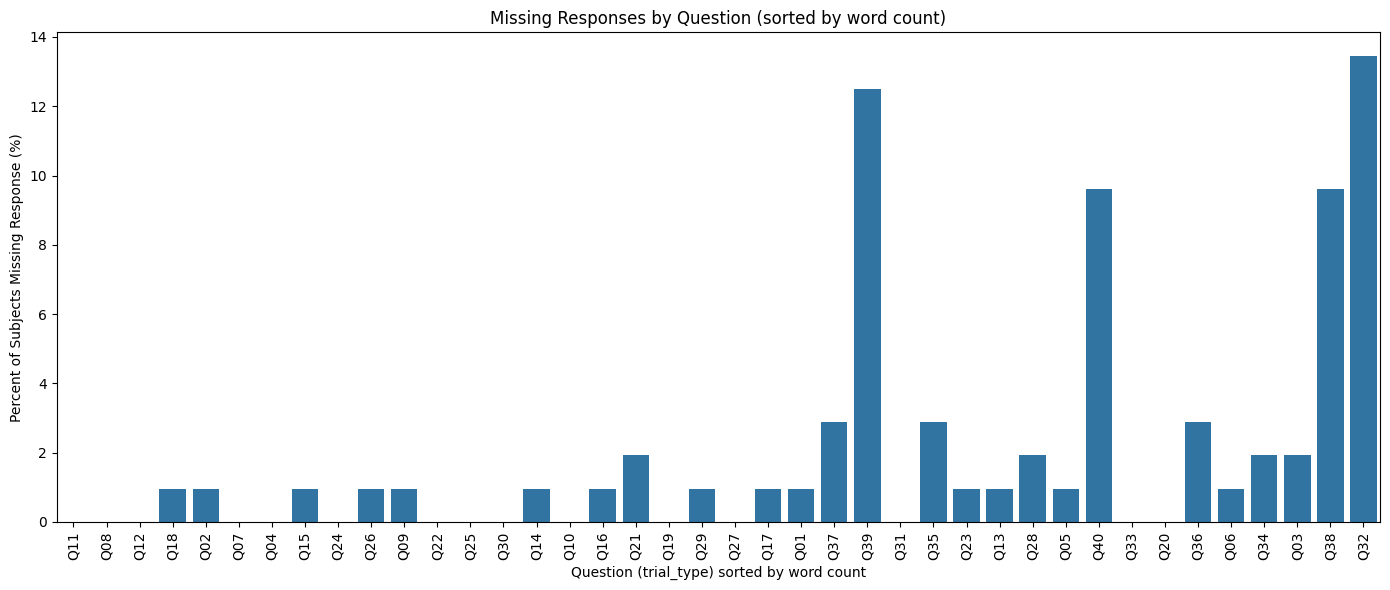

In [10]:
# Select rows where response_time is missing
missing_df = word_count_df[word_count_df['response_time'].isna()]

# Get a single word count per trial_type (they're all identical)
trial_word_count = word_count_df.drop_duplicates('trial_type').set_index('trial_type')[
    'word_count'
]

# Count missing responses per trial_type
missing_counts = missing_df['trial_type'].value_counts()
missing_percent = (missing_counts / total_subs) * 100

# Reorder trial_types by word_count
sorted_trial_types = trial_word_count.sort_values().index
missing_percent = missing_percent.reindex(sorted_trial_types, fill_value=0)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)

plt.xlabel('Question (trial_type) sorted by word count')
plt.ylabel('Percent of Subjects Missing Response (%)')
plt.title('Missing Responses by Question (sorted by word count)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

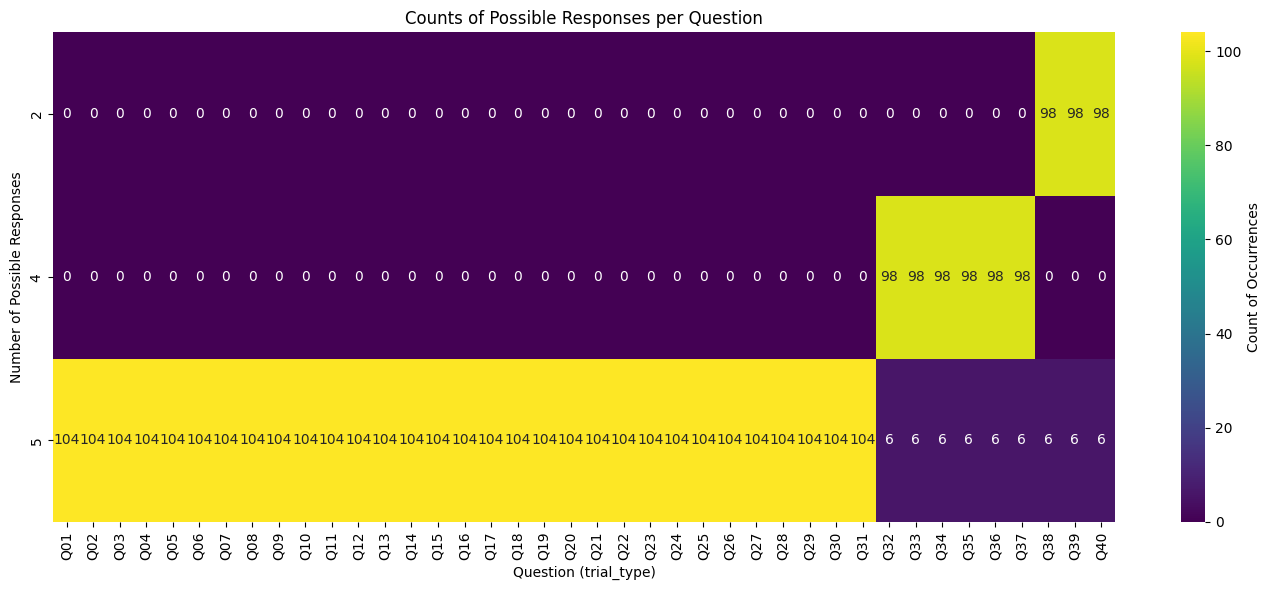

In [11]:
# I noticed the possible response counts might vary across subjects?
heatmap_data = pd.crosstab(
    word_count_df['num_possible_responses'], word_count_df['trial_type']
)

# Sort columns by trial_type
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,  # show counts in cells
    fmt='d',
    cbar_kws={'label': 'Count of Occurrences'},
)

plt.xlabel('Question (trial_type)')
plt.ylabel('Number of Possible Responses')
plt.title('Counts of Possible Responses per Question')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

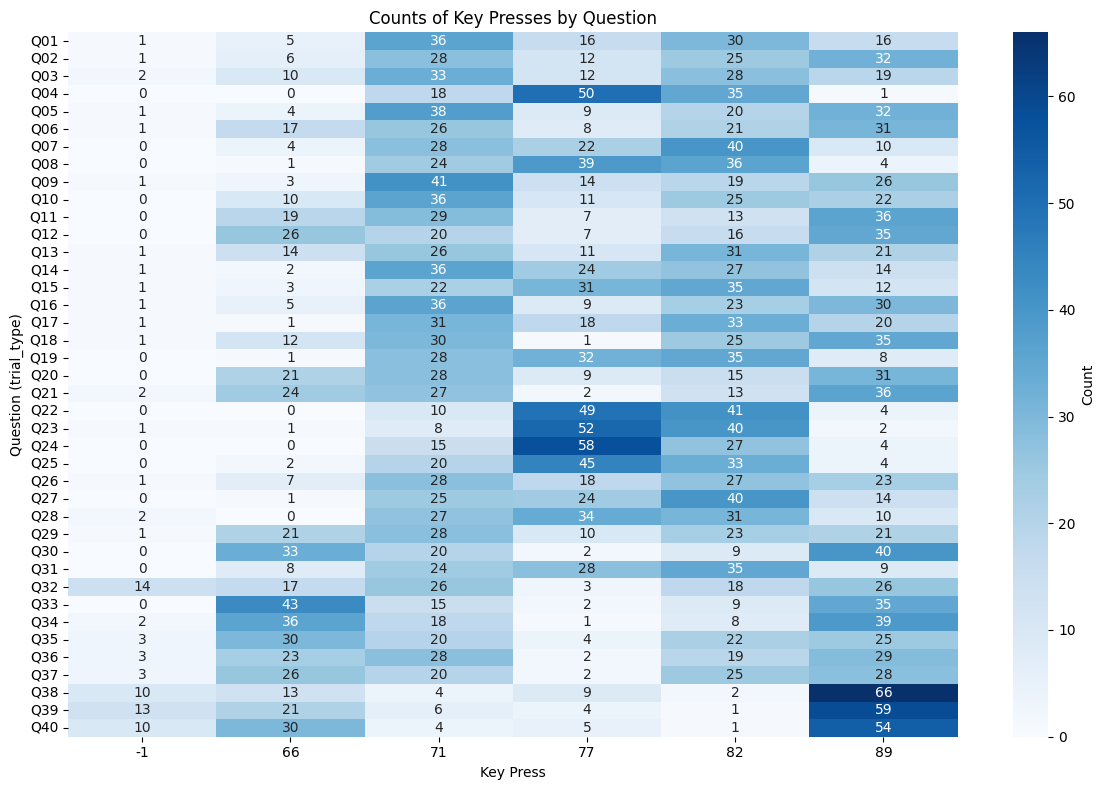

In [12]:
# button presses by question

heatmap_df = word_count_df.copy()
heatmap_df['trial_type'] = heatmap_df['trial_type'].astype(str)

# Create pivot table: rows = trial_type, columns = key_press, values = count
pivot = heatmap_df.pivot_table(
    index='trial_type',
    columns='key_press',
    aggfunc='size',  # count occurrences
    fill_value=0,
)

# Sort trial_types (questions) by natural order
sorted_trial_types = sorted(
    pivot.index, key=lambda x: int(x[1:])
)  # assumes 'Q01', 'Q02', etc.
pivot = pivot.reindex(sorted_trial_types)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'Count'})
plt.xlabel('Key Press')
plt.ylabel('Question (trial_type)')
plt.title('Counts of Key Presses by Question')
plt.tight_layout()
plt.show()

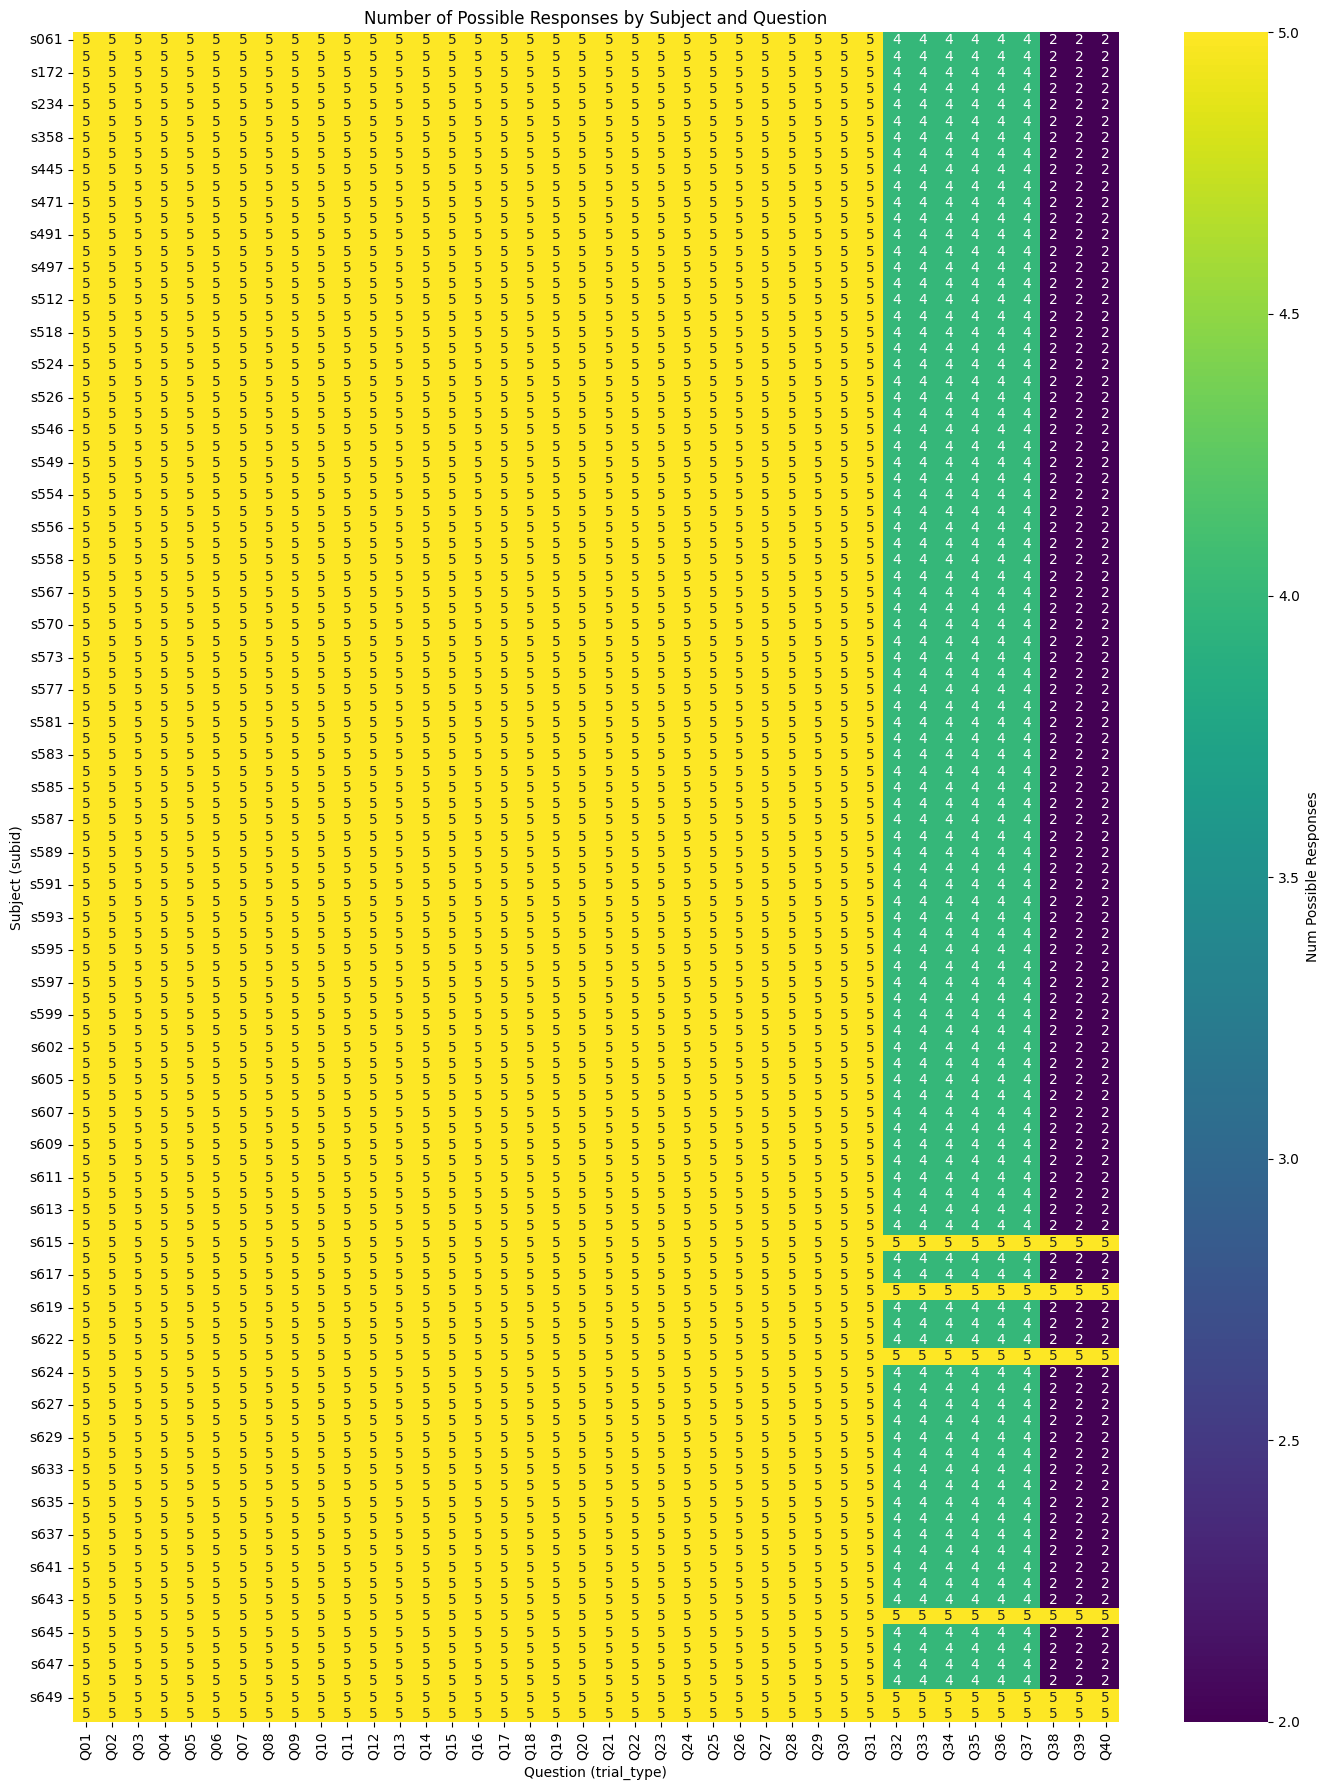

In [13]:
# trying to understand why there's a range of responses and whether the instructions may have changed.  Assuming the subject id is loosely related to date (but this may not be true)

heatmap_df = word_count_df.copy()
heatmap_df['trial_type'] = heatmap_df['trial_type'].astype(str)

# Pivot: rows=subid, columns=trial_type, values=num_possible_responses
pivot = heatmap_df.pivot_table(
    index='subid',
    columns='trial_type',
    values='num_possible_responses',
    aggfunc='first',  # only one value per subid x trial_type
)

# Sort subids and trial_types
pivot = pivot.sort_index()  # sort subjects
pivot = pivot.reindex(
    sorted(pivot.columns, key=lambda x: int(x[1:])), axis=1
)  # sort questions

# Plot heatmap
plt.figure(figsize=(14, 18))
sns.heatmap(
    pivot,
    cmap='viridis',
    annot=True,
    fmt='d',
    cbar_kws={'label': 'Num Possible Responses'},
)

plt.xlabel('Question (trial_type)')
plt.ylabel('Subject (subid)')
plt.title('Number of Possible Responses by Subject and Question')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

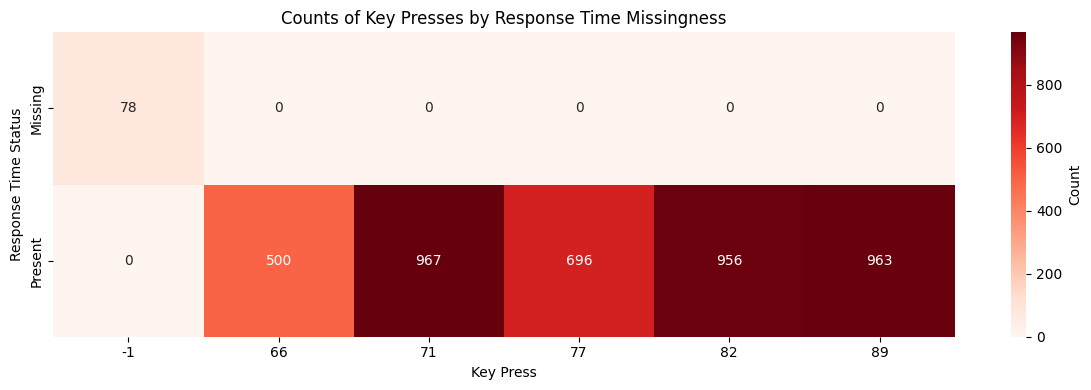

In [14]:
# I wanted to be sure a missing RT corresponded with a key press of -1

# Copy the dataframe and create a missingness column
heatmap_df = word_count_df.copy()
heatmap_df['response_missing'] = (
    heatmap_df['response_time'].isna().map({True: 'Missing', False: 'Present'})
)

# Create pivot table: rows = response_missing, columns = key_press, values = count
pivot = heatmap_df.pivot_table(
    index='response_missing', columns='key_press', aggfunc='size', fill_value=0
)

# Sort columns numerically for key_press if needed
pivot = pivot.reindex(sorted(pivot.columns), axis=1)

# Plot heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(pivot, cmap='Reds', annot=True, fmt='d', cbar_kws={'label': 'Count'})
plt.xlabel('Key Press')
plt.ylabel('Response Time Status')
plt.title('Counts of Key Presses by Response Time Missingness')
plt.tight_layout()
plt.show()


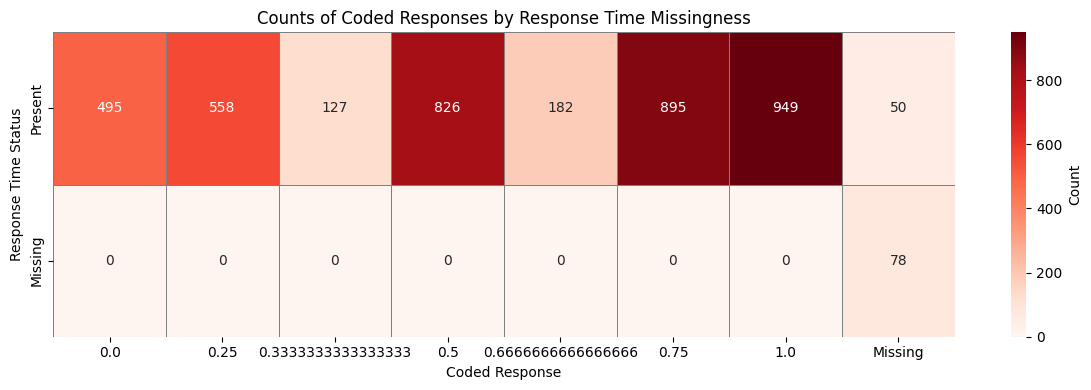

In [15]:
# technically, missing is indicated by coded_response having a value of NaN
# This makes sense.  Eyeballing the question by key_press grid, it looks like about 50 responses
# were for button presses that were not using acceptable buttons for that question (e.g. yes/no or 3 level responses)


# Copy dataframe
heatmap_df = word_count_df.copy()

# Create a column where coded_response numeric values stay, NaNs become 'Missing'
heatmap_df['coded_response_label'] = heatmap_df['coded_response'].astype(object)
heatmap_df['coded_response_label'] = heatmap_df['coded_response_label'].where(
    ~heatmap_df['coded_response_label'].isna(), other='Missing'
)

# Optional: track response_time missingness
heatmap_df['response_missing'] = (
    heatmap_df['response_time'].isna().map({True: 'Missing', False: 'Present'})
)

# Create pivot table WITHOUT automatic sorting
pivot = heatmap_df.pivot_table(
    index='response_missing',
    columns='coded_response_label',
    aggfunc='size',
    fill_value=0,
    sort=False,  # <--- important: prevents trying to sort str and float
)

# Sort columns manually: numeric first, then 'Missing'
numeric_cols = sorted([c for c in pivot.columns if c != 'Missing'])
if 'Missing' in pivot.columns:
    pivot = pivot[numeric_cols + ['Missing']]
else:
    pivot = pivot[numeric_cols]

# Plot heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(
    pivot,
    cmap='Reds',
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Count'},
)
plt.xlabel('Coded Response')
plt.ylabel('Response Time Status')
plt.title('Counts of Coded Responses by Response Time Missingness')
plt.tight_layout()
plt.show()


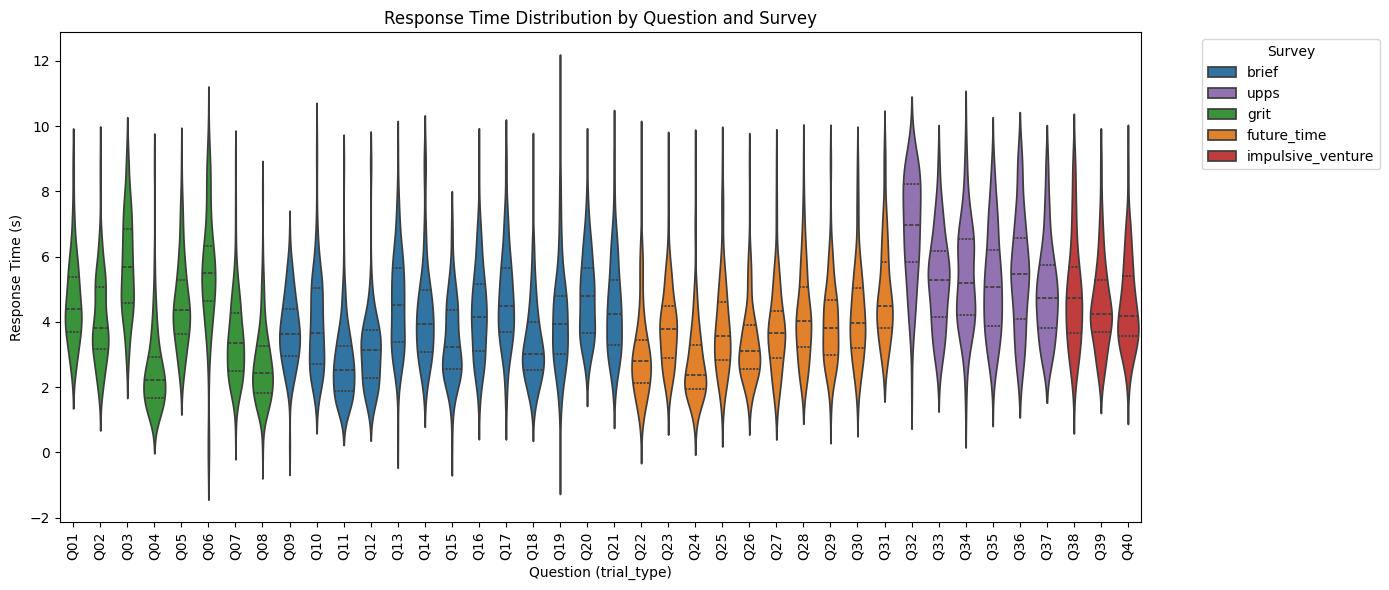

In [16]:
word_count_df['trial_type'] = word_count_df['trial_type'].astype(str)
sorted_trial_types = sorted(word_count_df['trial_type'].unique())

# Create a color palette for the surveys
surveys = np.sort(word_count_df['survey'].unique())
palette = dict(zip(surveys, sns.color_palette('tab10', n_colors=len(surveys))))

plt.figure(figsize=(14, 6))

# Violin plot, colored by survey
sns.violinplot(
    data=word_count_df,
    x='trial_type',
    y='response_time',
    order=sorted_trial_types,
    hue='survey',  # color by survey
    palette=palette,
    split=False,  # each violin is single color
    inner='quartile',
)

plt.xlabel('Question (trial_type)')
plt.ylabel('Response Time (s)')
plt.title('Response Time Distribution by Question and Survey')
plt.xticks(rotation=90)
plt.legend(title='Survey', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

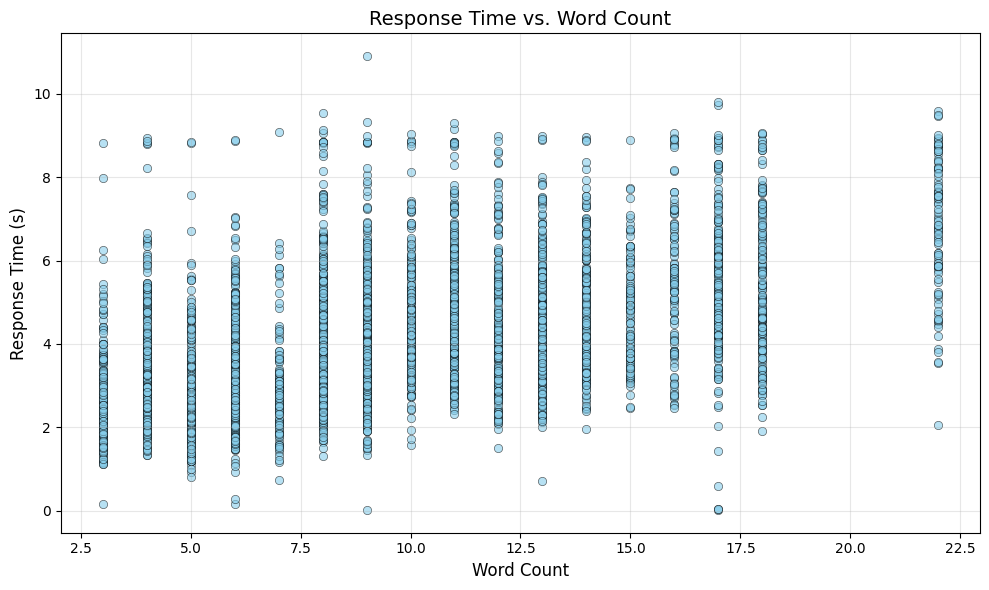

In [17]:
scatter_df = word_count_df.dropna(subset=['response_time'])

plt.figure(figsize=(10, 6))

plt.scatter(
    scatter_df['word_count'],
    scatter_df['response_time'],
    alpha=0.6,  # make points a bit transparent
    edgecolor='k',  # add black edge for clarity
    linewidth=0.5,
    color='skyblue',  # nice blue color
)

plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Response Time (s)', fontsize=12)
plt.title('Response Time vs. Word Count', fontsize=14)
plt.grid(alpha=0.3)  # subtle grid
plt.tight_layout()
plt.show()

/tmp/ipykernel_3633/3558832370.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


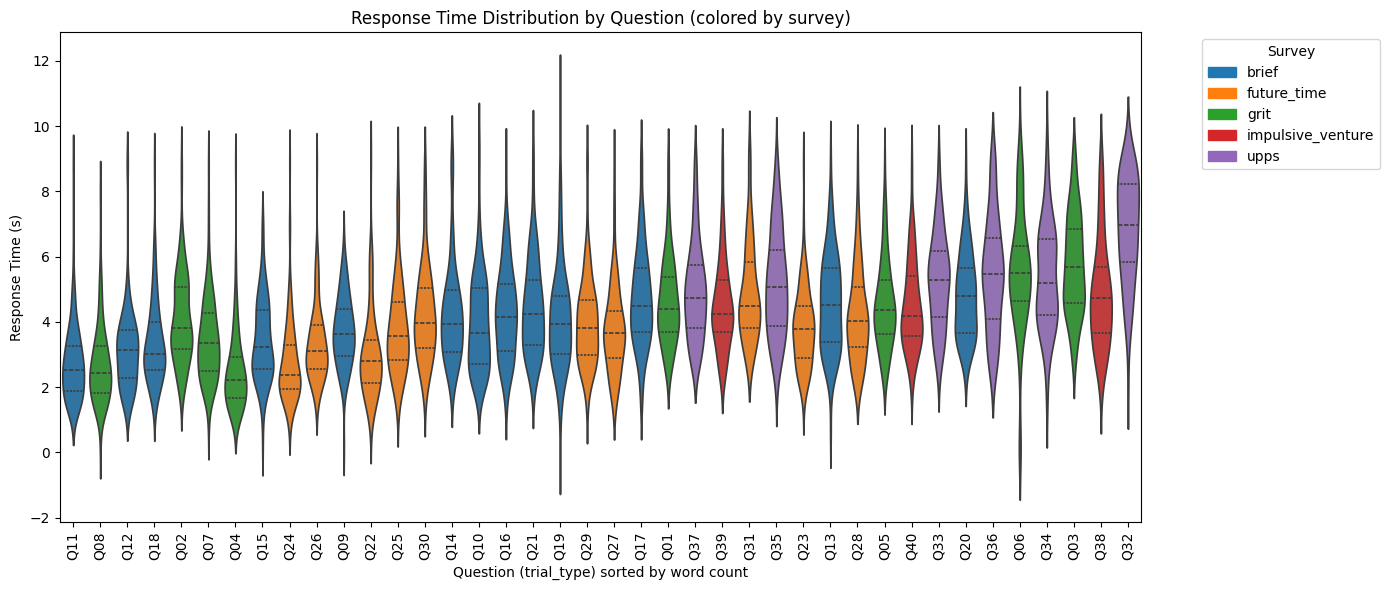

In [18]:
import matplotlib.patches as mpatches

plot_df = scatter_df.copy()

# Get a single word count per trial_type (all are the same across subjects)
trial_word_count = plot_df.drop_duplicates('trial_type').set_index('trial_type')[
    'word_count'
]

# Sort trial_types by word count
sorted_trial_types = trial_word_count.sort_values().index

# Create a mapping from trial_type to survey
trial_survey_map = (
    plot_df.drop_duplicates('trial_type').set_index('trial_type')['survey'].to_dict()
)

# Create a color palette for surveys
surveys = np.sort(plot_df['survey'].unique())
survey_palette = dict(zip(surveys, sns.color_palette('tab10', n_colors=len(surveys))))

# Map colors to trial_types based on their survey
violin_colors = [survey_palette[trial_survey_map[tt]] for tt in sorted_trial_types]

plt.figure(figsize=(14, 6))

sns.violinplot(
    data=plot_df,
    x='trial_type',
    y='response_time',
    order=sorted_trial_types,
    inner='quartile',
    palette=violin_colors,
)

plt.xlabel('Question (trial_type) sorted by word count')
plt.ylabel('Response Time (s)')
plt.title('Response Time Distribution by Question (colored by survey)')
plt.xticks(rotation=90)

# Add manual legend
handles = [
    mpatches.Patch(color=col, label=survey) for survey, col in survey_palette.items()
]
plt.legend(handles=handles, title='Survey', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## How often is the button press after the trial offset?

In [19]:
response_time_list = []
onset_list = []
key_press_list = []
trial_type_list = []
subid_list = []

for subid in subids:
    try:
        behav_file = resolve_file(cfg, subid, 'behav')
    except ValueError:
        print(f'Skipping sub-{subid}: behav file not found')
        continue

    events = load_tsv_data(behav_file)

    # Append relevant columns
    response_time_list.extend(events['response_time'].tolist())
    onset_list.extend(events['onset'].tolist())
    key_press_list.extend(events['key_press'].tolist())
    trial_type_list.extend(events['trial_type'].tolist())
    subid_list.extend([subid] * len(events))

# Create DataFrame
response_df = pd.DataFrame(
    {
        'subid': subid_list,
        'trial_type': trial_type_list,
        'onset': onset_list,
        'response_time': response_time_list,
        'key_press': key_press_list,
    }
)

# -----------------------------
# Compute rt_wrt_next_trial
# -----------------------------
response_df = response_df.sort_values(['subid', 'onset']).reset_index(drop=True)
response_df['rt_wrt_next_trial'] = np.nan

for subid, sub_df in response_df.groupby('subid', sort=False):
    idx = sub_df.index
    next_onset = sub_df['onset'].shift(-1)
    next_onset.iloc[-1] = np.nan  # last trial has no next trial
    response_df.loc[idx, 'rt_wrt_next_trial'] = (
        sub_df['onset'] + sub_df['response_time']
    ) - next_onset


Skipping sub-s144: behav file not found
Skipping sub-s533: behav file not found
Skipping sub-s600: behav file not found
Skipping sub-s603: behav file not found
Skipping sub-s639: behav file not found
Skipping sub-s640: behav file not found


In [20]:
rt_next = response_df['rt_wrt_next_trial'].dropna()

# Count how many are positive
num_positive = (rt_next > 0).sum()
total = len(rt_next)
percent_positive = 100 * num_positive / total

print(
    f'Positive rt_wrt_next_trial: {num_positive}/{total} trials ({percent_positive:.1f}%)'
)

Positive rt_wrt_next_trial: 1/3987 trials (0.0%)


In [21]:
rt = response_df['response_time'].dropna()

num_gt = (rt > 8.5).sum()
total = len(rt)
percent_gt = 100 * num_gt / total

print(f'RT > 8.5 sec: {num_gt}/{total} trials ({percent_gt:.2f}%)')

RT > 8.5 sec: 100/4082 trials (2.45%)


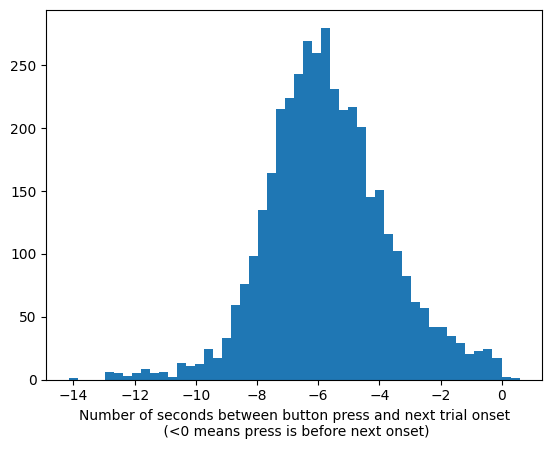

In [22]:
plt.hist(response_df['rt_wrt_next_trial'], 50)
plt.xlabel(
    'Number of seconds between button press and next trial onset\n (<0 means press is before next onset)'
)
plt.show()

## Understanding how coded_response works

In [23]:
subid_list = []
trial_type_list = []
key_press_list = []
coded_response_list = []

for subid in subids:
    try:
        behav_file = resolve_file(cfg, subid, 'behav')
    except ValueError:
        print(f'Skipping sub-{subid}: behav file not found')
        continue

    events = load_tsv_data(behav_file)

    # Append relevant columns
    trial_type_list.extend(events['trial_type'].tolist())
    key_press_list.extend(events['key_press'].tolist())
    coded_response_list.extend(events['coded_response'].tolist())
    subid_list.extend([subid] * len(events))

# Create DataFrame
coded_response_df = pd.DataFrame(
    {
        'subid': subid_list,
        'trial_type': trial_type_list,
        'key_press': key_press_list,
        'coded_response': coded_response_list,
    }
)

coded_response_df.head()

Skipping sub-s144: behav file not found
Skipping sub-s533: behav file not found
Skipping sub-s600: behav file not found
Skipping sub-s603: behav file not found
Skipping sub-s639: behav file not found
Skipping sub-s640: behav file not found


,subid,trial_type,key_press,coded_response
0,s061,Q17,82,0.250000
1,s061,Q32,89,0.666667
2,s061,Q09,71,0.500000
3,s061,Q01,71,0.500000
4,s061,Q30,71,0.500000


In [24]:
np.unique(coded_response_df['coded_response'])

array([0.        , 0.25      , 0.33333333, 0.5       , 0.66666667,
       0.75      , 1.        ,        nan])

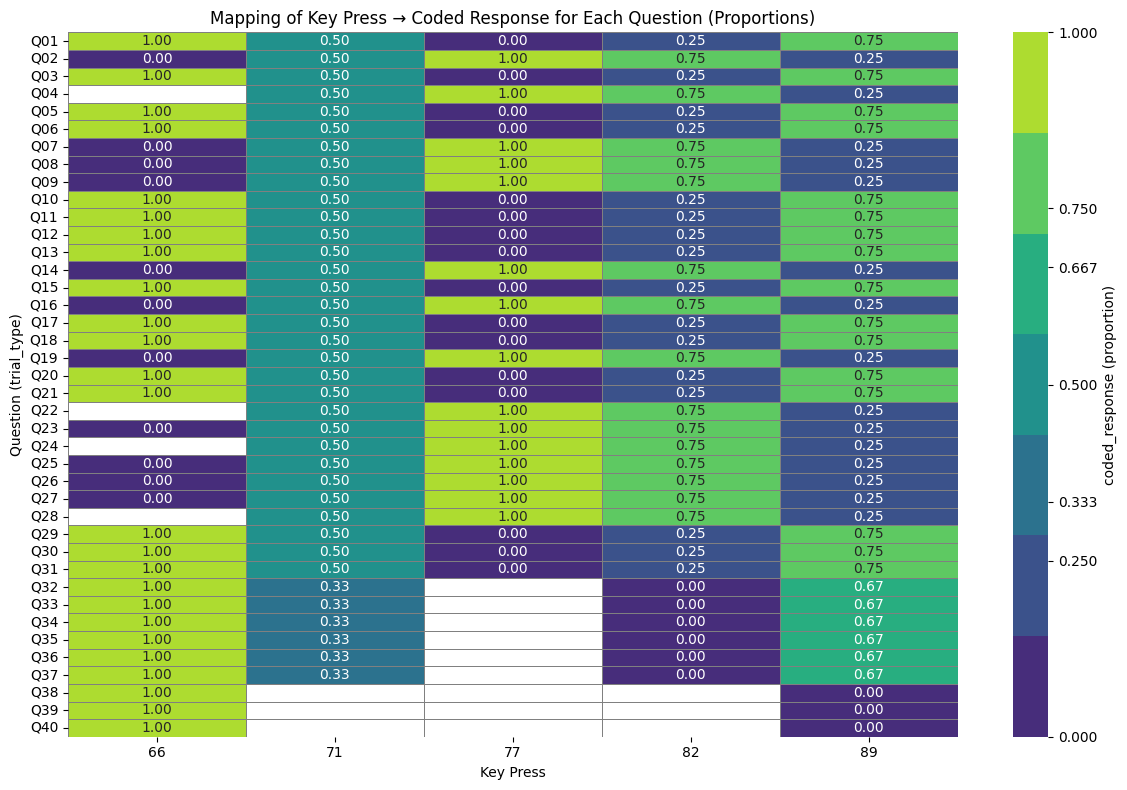

In [25]:
pivot = coded_response_df.pivot_table(
    index='trial_type',  # y-axis
    columns='key_press',  # x-axis
    values='coded_response',  # color
    aggfunc='mean',  # average if multiple entries per trial_type/key_press
)

# Sort trial_types naturally (Q01, Q02, ...)
pivot = pivot.reindex(sorted(pivot.index, key=lambda x: int(x[1:])))


# Create a list of the unique values (sorted) that appear in your data
# unique_vals = [0.0, 0.25, 0.33333333, 0.5, 0.66666667, 0.75, 1.0]
unique_vals = np.unique(coded_response_df['coded_response'])
unique_vals = unique_vals[~np.isnan(unique_vals)]
# Create a discrete colormap with as many colors as there are unique values
cmap = sns.color_palette('viridis', n_colors=len(unique_vals))

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={
        'label': 'coded_response (proportion)',
        'ticks': unique_vals,
    },
    vmin=min(unique_vals),
    vmax=max(unique_vals),
)

plt.title('Mapping of Key Press → Coded Response for Each Question (Proportions)')
plt.xlabel('Key Press')
plt.ylabel('Question (trial_type)')
plt.tight_layout()
plt.show()